## Introduction to SNAP

### Overview

The Sentinel Application Platform - or SNAP - in short is a collection of executable tools and Application Programming Interfaces (APIs) which have been developed to facilitate the utilisation, viewing and processing of a variety of remotely sensed data. The functionality of SNAP is accessed through the Sentinel Toolbox. The purpose of the Sentinel Toolbox is not to duplicate existing commercial packages, but to complement them with functions dedicated to the handling of data products of earth observing satellites.

The main components of the Sentinel Toolbox are:

* An intuitive desktop application used for EO data visualisation, analysing and processing.
* A set of scientific data processors running either from the command-line or invoked by the desktop application.
* The command-line tool gpt (graph processing tool) is used to execute processing graphs made up of operators nodes developed using the SNAP GPF (see Java API below).
* A data product converter tool pconvert allowing a user to convert raw data products to the BEAM-DIMAP standard format, to GeoTIFF, to HDF-5 or to RGB images.
* A Java™ API which provides ready-to-use components for remote sensing related application development and plug-in points for new SNAP extension modules. Besides a number of extension points such as product reader and writers, the SNAP API comprises the Graph Processing Framework (GPF) which is used to rapidly create raster data processors. The Rich Client Platform is used to develop rich GUI user interface applications based on SNAP.

### The SNAP Graph Processing Framework (GPF)

Within SNAP, the term data processor refers to a software module which creates an output product from one or more input products configured by a set of processing parameters. A product is basically a collection of bands which again provide numerical raster data for a spectral radiance, geophysical property or quality flag. 

As its name states, the GPF allows to construct directed, acyclic graphs (DAG) of processing nodes. A node in the graph refers to a GPF operator, which implements the algorithm to be executed. The node also has the role to configure the operation by specifying the operator's source nodes and providing values for the processing parameters. 

### Snappy 

It is possible to call SNAP code from your Python programs/scripts and to extend SNAP by plugins written in Python.

In [1]:
import snappy

### The SNAP Operators

In [2]:
snappy.GPF.getDefaultInstance().getOperatorSpiRegistry().loadOperatorSpis()

op_spi_it = snappy.GPF.getDefaultInstance().getOperatorSpiRegistry().getOperatorSpis().iterator()

while op_spi_it.hasNext():
    
    op_spi = op_spi_it.next()
    
    print(op_spi.getOperatorAlias(), op_spi.getOperatorDescriptor().getName())

('EAP-Phase-Correction', 'org.esa.s1tbx.sentinel1.gpf.EAPPhaseCorrectionOp')
('Apply-Orbit-File', 'org.esa.s1tbx.sar.gpf.orbits.ApplyOrbitFileOp')
('Idepix.Olci.Postprocess', 'org.esa.s3tbx.idepix.algorithms.olci.OlciPostProcessOp')
('SubGraph', 'org.esa.s1tbx.fex.gpf.SubGraphOp')
('Idepix.OrbView2.Seawifs', 'org.esa.s3tbx.idepix.algorithms.seawifs.SeaWifsOp')
('GaborFilter', 'org.esa.s1tbx.fex.gpf.texture.GaborFilterOp')
('Interferogram', 'org.esa.s1tbx.insar.gpf.InterferogramOp')
('NdtiOp', 'org.esa.s2tbx.radiometry.NdtiOp')
('Meris.CorrectRadiometry', 'org.esa.s3tbx.meris.radiometry.MerisRadiometryCorrectionOp')
('Speckle-Filter', 'org.esa.s1tbx.sar.gpf.filtering.SpeckleFilterOp')
('Meris.BlueBand', 'org.esa.s3tbx.meris.cloud.BlueBandOp')
('Idepix.Meris.Postprocess', 'org.esa.s3tbx.idepix.algorithms.meris.MerisPostProcessOp')
('AerosolRetrieval.Upscale', 'org.esa.s3tbx.aerosol.UpscaleOp')
('Idepix.Sentinel3.OlciSlstr', 'org.esa.s3tbx.idepix.algorithms.olcislstr.OlciSlstrOp')
('TOPSA

### Describe a SNAP Operator

SNAP Operators have several parameters, some with default values defined.



In [3]:
def op_help(op):
    
        op_spi = snappy.GPF.getDefaultInstance().getOperatorSpiRegistry().getOperatorSpi(op)
        
        print('Operator name: {}'.format(op_spi.getOperatorDescriptor().getName()))
        
        print('Operator alias: {}\n'.format(op_spi.getOperatorDescriptor().getAlias()))
        print('Parameters:\n')
        param_Desc = op_spi.getOperatorDescriptor().getParameterDescriptors()
        
        #value_set = param_Desc[0].getValueSet()
        #print(list(value_set))
        
        for param in param_Desc:
            print('{}: {}\nDefault Value: {}\n'.format(param.getName(),
                                                       param.getDescription(),
                                                       param.getDefaultValue()))
            
            print('Possible values: {}\n').format(list(param.getValueSet()))

For instance, here's the **Apply-Orbit-File** SNAP Operator information 

In [4]:
op_help('Apply-Orbit-File')

Operator name: org.esa.s1tbx.sar.gpf.orbits.ApplyOrbitFileOp
Operator alias: Apply-Orbit-File

Parameters:

orbitType: None
Default Value: Sentinel Precise (Auto Download)

Possible values: ['Sentinel Precise (Auto Download)', 'Sentinel Restituted (Auto Download)', 'DORIS Preliminary POR (ENVISAT)', 'DORIS Precise VOR (ENVISAT) (Auto Download)', 'DELFT Precise (ENVISAT, ERS1&2) (Auto Download)', 'PRARE Precise (ERS1&2) (Auto Download)', 'Kompsat5 Precise']

polyDegree: None
Default Value: 3

Possible values: []

continueOnFail: None
Default Value: false

Possible values: []



### Implement a Graph to generate Sigma0

Goal:

Create a quicklook of the Sentinel-1 product downloaded previously.

The Graph will thus:

- Read the Sentinel-1 product
- Create a 3-band product with Intensity_HH, Intensity_HV and Intensity_HH/Intensity_HV
- Write the product

This (direct acyclic) processing graph will thus combine in a XML file the SNAP Operators:

- Read to read the product
- BandMaths to create the 3-bands product
- Write to write the product on the file system

The can graph be depicted as:

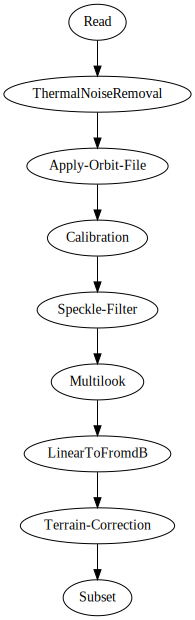

In [5]:
from graphviz import Digraph

dot = Digraph()
dot.node('A', 'Read')
dot.node('B', 'ThermalNoiseRemoval')
dot.node('C', 'Apply-Orbit-File')
dot.node('D', 'Calibration')
dot.node('E', 'Speckle-Filter')
dot.node('F', 'Multilook')
dot.node('G', 'LinearToFromdB')
dot.node('H', 'Terrain-Correction')
dot.node('I', 'Subset')


dot.edges(['AB', 'BC', 'CD', 'DE', 'EF', 'FG', 'GH', 'HI'])

dot

To ease this process, there's a Python class and few helper functions that create the XML file and runs it.

In [6]:
%load_ext autoreload
%autoreload 2

import sys
import os
sys.path.append(os.getcwd())
import ellip_snap_helpers

In [7]:
mygraph = ellip_snap_helpers.GraphProcessor()

Now let's learn a bit more about the SNAP Operators, starting with the Read Operator.

#### Read

In [8]:
op_help('Read')

Operator name: org.esa.snap.core.gpf.common.ReadOp
Operator alias: Read

Parameters:

file: The file from which the data product is read.
Default Value: None

Possible values: []

formatName: An (optional) format name.
Default Value: None

Possible values: []



Let's create the first node of the Graph where:

* the variable **operator** is the name of the SNAP Operator
* the variable **node_id** is the name of the node being created
* the variable **source_node_id** is the source node(s) - Read is the first node so there isn't any source node

In [9]:
operator = 'Read'

node_id = 'Read'

source_node_id = ''

Get the set of default parameters for the Read SNAP Operator:

In [10]:
parameters = ellip_snap_helpers.get_operator_default_parameters(operator)

Replace the default value for the parameter **file** with the path to the Sentinel-1 product

In [11]:
parameters['file'] = '/data2/S1B_EW_GRDM_1SDH_20180822T114138_20180822T114238_012375_016D07_E770.zip' 

Add the Read node to the Graph

In [12]:
mygraph.add_node(node_id, operator, parameters, source_node_id)

At this stage, the Graph looks like: 

In [13]:
mygraph.view_graph()

<graph>
  <version>1.0</version>
  <node id="Read">
    <operator>Read</operator>
    <sources/>
    <parameters class="com.bc.ceres.binding.dom.XppDomElement">
      <formatName/>
      <file>/data2/S1B_EW_GRDM_1SDH_20180822T114138_20180822T114238_012375_016D07_E770.zip</file>
    </parameters>
  </node>
</graph>



#### ThermalNoiseRemoval

Thermal noise correction can be applied to Sentinel-1 Level-1 SLC products as well as Level-1 GRD products which have not already been corrected. The operator can also remove this correction based on the product annotations (i.e. to re-introduce the noise signal that was removed). Product annotations will be updated accordingly to allow for re-application of the correction. 

Level-1 products provide a noise LUT for each measurement data set. The values in the de-noise LUT, provided in linear power, can be used to derive calibrated noise profiles matching the calibrated GRD data.   

Bi-linear interpolation is used for any pixels that fall between points in the LUT.

Now for the **ThermalNoiseRemoval** Operator we follow a similar process:

In [14]:
op_help('ThermalNoiseRemoval')

Operator name: org.esa.s1tbx.calibration.gpf.Sentinel1RemoveThermalNoiseOp
Operator alias: ThermalNoiseRemoval

Parameters:

selectedPolarisations: The list of polarisations
Default Value: None

Possible values: []

removeThermalNoise: Remove thermal noise
Default Value: true

Possible values: []

reIntroduceThermalNoise: Re-introduce thermal noise
Default Value: false

Possible values: []



In [15]:
operator = 'ThermalNoiseRemoval'

node_id = 'ThermalNoiseRemoval' 

source_node_id = 'Read'

parameters = ellip_snap_helpers.get_operator_default_parameters(operator)

mygraph.add_node(node_id, operator, parameters, source_node_id)

#### Apply-Orbit-File

The orbit state vectors provided in the metadata of a SAR product are generally not accurate and can be refined with the precise orbit files which are available days-to-weeks after the generation of the product. 
The orbit file provides accurate satellite position and velocity information. Based on this information, the orbit state vectors in the abstract metadata of the product are updated.

For Sentinel-1, Restituted orbit files and Precise orbit files may be applied. Precise orbits are produced a few weeks after acquisition. Orbit files are automatically download from Array's servers by SNAP. If an orbit file is not found, you may try looking for it in https://qc.sentinel1.eo.esa.int/  and placing the downloaded file into the auxdata folder.

In [16]:
operator = 'Apply-Orbit-File'

node_id = 'Apply-Orbit-File' 

source_node_id = 'ThermalNoiseRemoval'

parameters = ellip_snap_helpers.get_operator_default_parameters(operator)

parameters

{'continueOnFail': 'false',
 'orbitType': 'Sentinel Precise (Auto Download)',
 'polyDegree': '3'}

In [17]:
mygraph.add_node(node_id, operator, parameters, source_node_id)

#### Calibration

The objective of SAR calibration is to provide imagery in which the pixel values can be directly related to the radar backscatter of the scene. Though uncalibrated SAR imagery is sufficient for qualitative use, calibrated SAR images are essential to quantitative use of SAR data.

Typical SAR data processing, which produces level 1 images, does not include radiometric corrections and significant radiometric bias remains. Therefore, it is necessary to apply the radiometric correction to SAR images so that the pixel values of the SAR images truly represent the radar backscatter of the reflecting surface. The radiometric correction is also necessary for the comparison of SAR images acquired with different sensors, or acquired from the same sensor but at different times, in different modes, or processed by different processors.

This Operator performs different calibrations for ASAR, ERS, ALOS and Radarsat-2 products deriving the sigma nought images. Optionally gamma nought and beta nought images can also be created.

In [18]:
operator = 'Calibration'

node_id = 'Calibration' 

source_node_id = 'Apply-Orbit-File'

parameters = ellip_snap_helpers.get_operator_default_parameters(operator)

parameters

{'auxFile': 'Latest Auxiliary File',
 'createBetaBand': 'false',
 'createGammaBand': 'false',
 'externalAuxFile': None,
 'outputBetaBand': 'false',
 'outputGammaBand': 'false',
 'outputImageInComplex': 'false',
 'outputImageScaleInDb': 'false',
 'outputSigmaBand': 'true',
 'selectedPolarisations': None,
 'sourceBandNames': None}

In [19]:
mygraph.add_node(node_id, operator, parameters, source_node_id)

#### Speckle-Filter

SAR images have inherent salt and pepper like texturing called speckles which degrade the quality of the image and make interpretation of features more difficult. Speckles are caused by random constructive and destructive interference of the de-phased but coherent return waves scattered by the elementary scatters within each resolution cell. Speckle noise reduction can be applied either by spatial filtering or multilook processing.

In [20]:
operator = 'Speckle-Filter'

node_id = 'Speckle-Filter' 

source_node_id = 'Calibration'

parameters = ellip_snap_helpers.get_operator_default_parameters(operator)

parameters

{'anSize': '50',
 'dampingFactor': '2',
 'enl': '1.0',
 'estimateENL': 'false',
 'filter': 'Lee Sigma',
 'filterSizeX': '3',
 'filterSizeY': '3',
 'numLooksStr': '1',
 'sigmaStr': '0.9',
 'sourceBandNames': None,
 'targetWindowSizeStr': '3x3',
 'windowSize': '7x7'}

In [21]:
mygraph.add_node(node_id, operator, parameters, source_node_id)

#### Multilook

Generally, a SAR original image appears speckled with inherent speckle noise. To reduce this inherent speckled appearance, several images are incoherently combined as if they corresponded to different looks of the same scene. This processing is generally known as multilook processing. As a result the multilooked image improves the image interpretability. Additionally, multilook processing can be used to produce an application product with nominal image pixel size. 

_Multilook Method_

There are two ways to implement the multilook processing: 

* The multilooked images can be produced by space-domain averaging of a single look image, either with or without specific 2D kernels by convolution.
* The multilook images can be produced by frequency-domain method using the sub-spectral band width.
  
This operator implements the space-domain multilook method by averaging a single look image with a small sliding window. 

_Selecting Range and Azimuth Looks_

In selecting the number of range looks and the number of azimuth looks, user has two options: 

* GR square pixel: the user specifies the number of range looks while the number of azimuth looks is computed based on the ground range spacing and the azimuth spacing. The window size is then determined by the number of range looks and the number of azimuth looks. As a result, image with approximately square pixel spacing on the ground is produced.
* Independent looks: the number of looks in range and azimuth can be selected independently. The window size is then determined by the number of range looks and the number of azimuth looks.

In [22]:
operator = 'Multilook'

node_id = 'Multilook' 

source_node_id = 'Speckle-Filter'

parameters = ellip_snap_helpers.get_operator_default_parameters(operator)

parameters

{'grSquarePixel': 'true',
 'nAzLooks': '1',
 'nRgLooks': '1',
 'outputIntensity': 'false',
 'sourceBandNames': None}

In [23]:
mygraph.add_node(node_id, operator, parameters, source_node_id)

#### LinearToFromdB

Converts bands to dB

In [24]:
operator = 'LinearToFromdB'

node_id = 'LinearToFromdB' 

source_node_id = 'Multilook'

parameters = ellip_snap_helpers.get_operator_default_parameters(operator)

parameters

{'sourceBandNames': None}

In [25]:
mygraph.add_node(node_id, operator, parameters, source_node_id)

### Terrain correction

In [26]:
operator = 'Terrain-Correction'

map_proj = """PROJCS["WGS 84 / Arctic Polar Stereographic", 
  GEOGCS["WGS 84", 
    DATUM["World Geodetic System 1984", 
      SPHEROID["WGS 84", 6378137.0, 298.257223563, AUTHORITY["EPSG","7030"]], 
      AUTHORITY["EPSG","6326"]], 
    PRIMEM["Greenwich", 0.0, AUTHORITY["EPSG","8901"]], 
    UNIT["degree", 0.017453292519943295], 
    AXIS["Geodetic longitude", EAST], 
    AXIS["Geodetic latitude", NORTH], 
    AUTHORITY["EPSG","4326"]], 
  PROJECTION["Polar Stereographic (variant B)", AUTHORITY["EPSG","9829"]], 
  PARAMETER["central_meridian", 0.0], 
  PARAMETER["Standard_Parallel_1", 71.0], 
  PARAMETER["false_easting", 0.0], 
  PARAMETER["false_northing", 0.0], 
  UNIT["m", 1.0], 
  AXIS["Easting", "South along 90 deg East"], 
  AXIS["Northing", "South along 180 deg"], 
  AUTHORITY["EPSG","3995"]]"""

node_id = 'Terrain-Correction' 

source_node_id = 'LinearToFromdB'

parameters = ellip_snap_helpers.get_operator_default_parameters(operator)

parameters['demName'] = 'ACE30'  
parameters['saveDEM'] = 'true'
parameters['mapProjection'] = map_proj
parameters['nodataValueAtSea'] = 'false'   
                
parameters
    




{'alignToStandardGrid': 'false',
 'applyRadiometricNormalization': 'false',
 'auxFile': 'Latest Auxiliary File',
 'demName': 'ACE30',
 'demResamplingMethod': 'BILINEAR_INTERPOLATION',
 'externalAuxFile': None,
 'externalDEMApplyEGM': 'true',
 'externalDEMFile': None,
 'externalDEMNoDataValue': '0',
 'imgResamplingMethod': 'BILINEAR_INTERPOLATION',
 'incidenceAngleForGamma0': 'Use projected local incidence angle from DEM',
 'incidenceAngleForSigma0': 'Use projected local incidence angle from DEM',
 'mapProjection': 'PROJCS["WGS 84 / Arctic Polar Stereographic", \n  GEOGCS["WGS 84", \n    DATUM["World Geodetic System 1984", \n      SPHEROID["WGS 84", 6378137.0, 298.257223563, AUTHORITY["EPSG","7030"]], \n      AUTHORITY["EPSG","6326"]], \n    PRIMEM["Greenwich", 0.0, AUTHORITY["EPSG","8901"]], \n    UNIT["degree", 0.017453292519943295], \n    AXIS["Geodetic longitude", EAST], \n    AXIS["Geodetic latitude", NORTH], \n    AUTHORITY["EPSG","4326"]], \n  PROJECTION["Polar Stereographic (var

In [27]:
mygraph.add_node(node_id, operator, parameters, source_node_id)

### Subset 

In [28]:
def extend_aoi(center_x, center_y, extent):
    
    polar_epsg = 3575 # 3995
    latlon_epsg = 4326
    
    center_polar = loads(convert_coords(latlon_epsg, polar_epsg, Point(center_x, center_y).wkt))
    
    ll = convert_coords(polar_epsg, latlon_epsg, Point(center_polar.x - extent,  center_polar.y - extent).wkt)
    lr = convert_coords(polar_epsg, latlon_epsg, Point(center_polar.x + extent,  center_polar.y - extent).wkt)
    ur = convert_coords(polar_epsg, latlon_epsg, Point(center_polar.x + extent,  center_polar.y + extent).wkt)
    ul = convert_coords(polar_epsg, latlon_epsg, Point(center_polar.x - extent,  center_polar.y + extent).wkt)


    pointList = [loads(ll),
             loads(lr), 
             loads(ur), 
             loads(ul), 
             loads(ll)]

    extended_aoi = geometry.Polygon([[p.x, p.y] for p in pointList]).wkt
    
    return extended_aoi

In [29]:
def convert_coords(source_epsg, target_epsg, geom):

    source = osr.SpatialReference()
    source.ImportFromEPSG(source_epsg)

    target = osr.SpatialReference()
    target.ImportFromEPSG(target_epsg)

    transform = osr.CoordinateTransformation(source, target)

    point = ogr.CreateGeometryFromWkt(geom)
    point.Transform(transform)

    return point.ExportToWkt()

In [31]:
from shapely.wkt import loads

poi = loads('POINT (-35.3 83.90000000000001)')

In [36]:
from shapely.geometry import Point
import osr
import ogr
from shapely import geometry

extended_aoi = extend_aoi(poi.x, poi.y, 50000)

extended_aoi

'POLYGON ((-35.2717796499525 83.2658579085283, -29.3687708669507 83.8704727024008, -35.334759858866 84.53393836008161, -41.2248291287458 83.8638684209569, -35.2717796499525 83.2658579085283))'

In [37]:
operator = 'Subset'

node_id = 'Subset' 

source_node_id = 'Terrain-Correction'

parameters = ellip_snap_helpers.get_operator_default_parameters(operator)

parameters['geoRegion'] = extended_aoi 

parameters

{'bandNames': None,
 'copyMetadata': 'false',
 'fullSwath': 'false',
 'geoRegion': 'POLYGON ((-35.2717796499525 83.2658579085283, -29.3687708669507 83.8704727024008, -35.334759858866 84.53393836008161, -41.2248291287458 83.8638684209569, -35.2717796499525 83.2658579085283))',
 'region': None,
 'subSamplingX': '1',
 'subSamplingY': '1',
 'tiePointGridNames': None}

In [38]:
mygraph.add_node(node_id, operator, parameters, source_node_id)


#### Write

Add the Write node:

In [39]:
op_help('Write')

Operator name: org.esa.snap.core.gpf.common.WriteOp
Operator alias: Write

Parameters:

file: The output file to which the data product is written.
Default Value: None

Possible values: []

formatName: The name of the output file format.
Default Value: BEAM-DIMAP

Possible values: []

deleteOutputOnFailure: If true, all output files are deleted after a failed write operation.
Default Value: true

Possible values: []

writeEntireTileRows: If true, the write operation waits until an entire tile row is computed.
Default Value: true

Possible values: []

clearCacheAfterRowWrite: If true, the internal tile cache is cleared after a tile row has been written. Ignored if writeEntireTileRows=false.
Default Value: false

Possible values: []



In [40]:
operator = 'Write'

node_id = 'Write'

source_node_id = 'Subset'

In [41]:
parameters = ellip_snap_helpers.get_operator_default_parameters(operator)

parameters

{'clearCacheAfterRowWrite': 'false',
 'deleteOutputOnFailure': 'true',
 'file': None,
 'formatName': 'BEAM-DIMAP',
 'writeEntireTileRows': 'true'}

In [42]:


ProductIOPlugInManager = snappy.jpy.get_type('org.esa.snap.core.dataio.ProductIOPlugInManager')

ProductWriterPlugIn = snappy.jpy.get_type('org.esa.snap.core.dataio.ProductWriterPlugIn')

write_plugins = ProductIOPlugInManager.getInstance().getAllWriterPlugIns()

print('Writer formats')
while write_plugins.hasNext():
    plugin = write_plugins.next()
    print(plugin.getDefaultFileExtensions()[0],  plugin.getFormatNames()[0])



Writer formats
('.ntf', 'GDAL-NITF-WRITER')
('.h5', 'HDF5')
('.jp2', 'JPEG2000')
('.tif', 'GDAL-GTiff-WRITER')
('.bin', 'Generic Binary BSQ')
('.hdr', 'ENVI')
('.hdr', 'GDAL-MFF-WRITER')
('.rst', 'GDAL-RST-WRITER')
('.par', 'Gamma')
('.sdat', 'GDAL-SAGA-WRITER')
('.dim', 'BEAM-DIMAP')
('.rsw', 'GDAL-RMF-WRITER')
('.hdr', 'Snaphu')
('.csv', 'CSV')
('.nc', 'NetCDF-CF')
('.mpr', 'GDAL-ILWIS-WRITER')
('.grd', 'GDAL-GSBG-WRITER')
('jpg', 'JP2')
('.nc', 'NetCDF-BEAM')
('.tif', 'GeoTIFF+XML')
('.grd', 'GDAL-GS7BG-WRITER')
('.bt', 'GDAL-BT-WRITER')
('.nc', 'NetCDF4-CF')
('.gtx', 'GDAL-GTX-WRITER')
('.rgb', 'GDAL-SGI-WRITER')
('.bmp', 'GDAL-BMP-WRITER')
('.img', 'GDAL-HFA-WRITER')
('.pix', 'GDAL-PCIDSK-WRITER')
('.hdr', 'PolSARPro')
('.pnm', 'GDAL-PNM-WRITER')
('.kro', 'GDAL-KRO-WRITER')
('.nc', 'NetCDF4-BEAM')
('.tif', 'GeoTIFF')
('.tif', 'GeoTIFF-BigTIFF')


In [43]:
parameters['file'] = 's1_quicklook'
parameters['formatName'] = 'GeoTIFF-BigTiff'

In [44]:
mygraph.add_node(node_id, operator, parameters, source_node_id)

In [45]:
mygraph.view_graph()

<graph>
  <version>1.0</version>
  <node id="Read">
    <operator>Read</operator>
    <sources/>
    <parameters class="com.bc.ceres.binding.dom.XppDomElement">
      <formatName/>
      <file>/data2/S1B_EW_GRDM_1SDH_20180822T114138_20180822T114238_012375_016D07_E770.zip</file>
    </parameters>
  </node>
  <node id="ThermalNoiseRemoval">
    <operator>ThermalNoiseRemoval</operator>
    <sources>
      <sourceProduct refid="Read"/>
    </sources>
    <parameters class="com.bc.ceres.binding.dom.XppDomElement">
      <reIntroduceThermalNoise>false</reIntroduceThermalNoise>
      <selectedPolarisations/>
      <removeThermalNoise>true</removeThermalNoise>
    </parameters>
  </node>
  <node id="Apply-Orbit-File">
    <operator>Apply-Orbit-File</operator>
    <sources>
      <sourceProduct refid="ThermalNoiseRemoval"/>
    </sources>
    <parameters class="com.bc.ceres.binding.dom.XppDomElement">
      <polyDegree>3</polyDegree>
      <orbitType>Sentinel Precise (Auto Download)</orbitType>

In [46]:
mygraph.run()

Processing the graph
Process PID: 6019
Executing processing graph
....10%....20%....30%....40%....50%....60%....70%....80%....90% done.
INFO: org.esa.snap.core.gpf.operators.tooladapter.ToolAdapterIO: Initializing external tool adapters
INFO: org.hsqldb.persist.Logger: dataFileCache open start

Done.


### Plot the quicklook

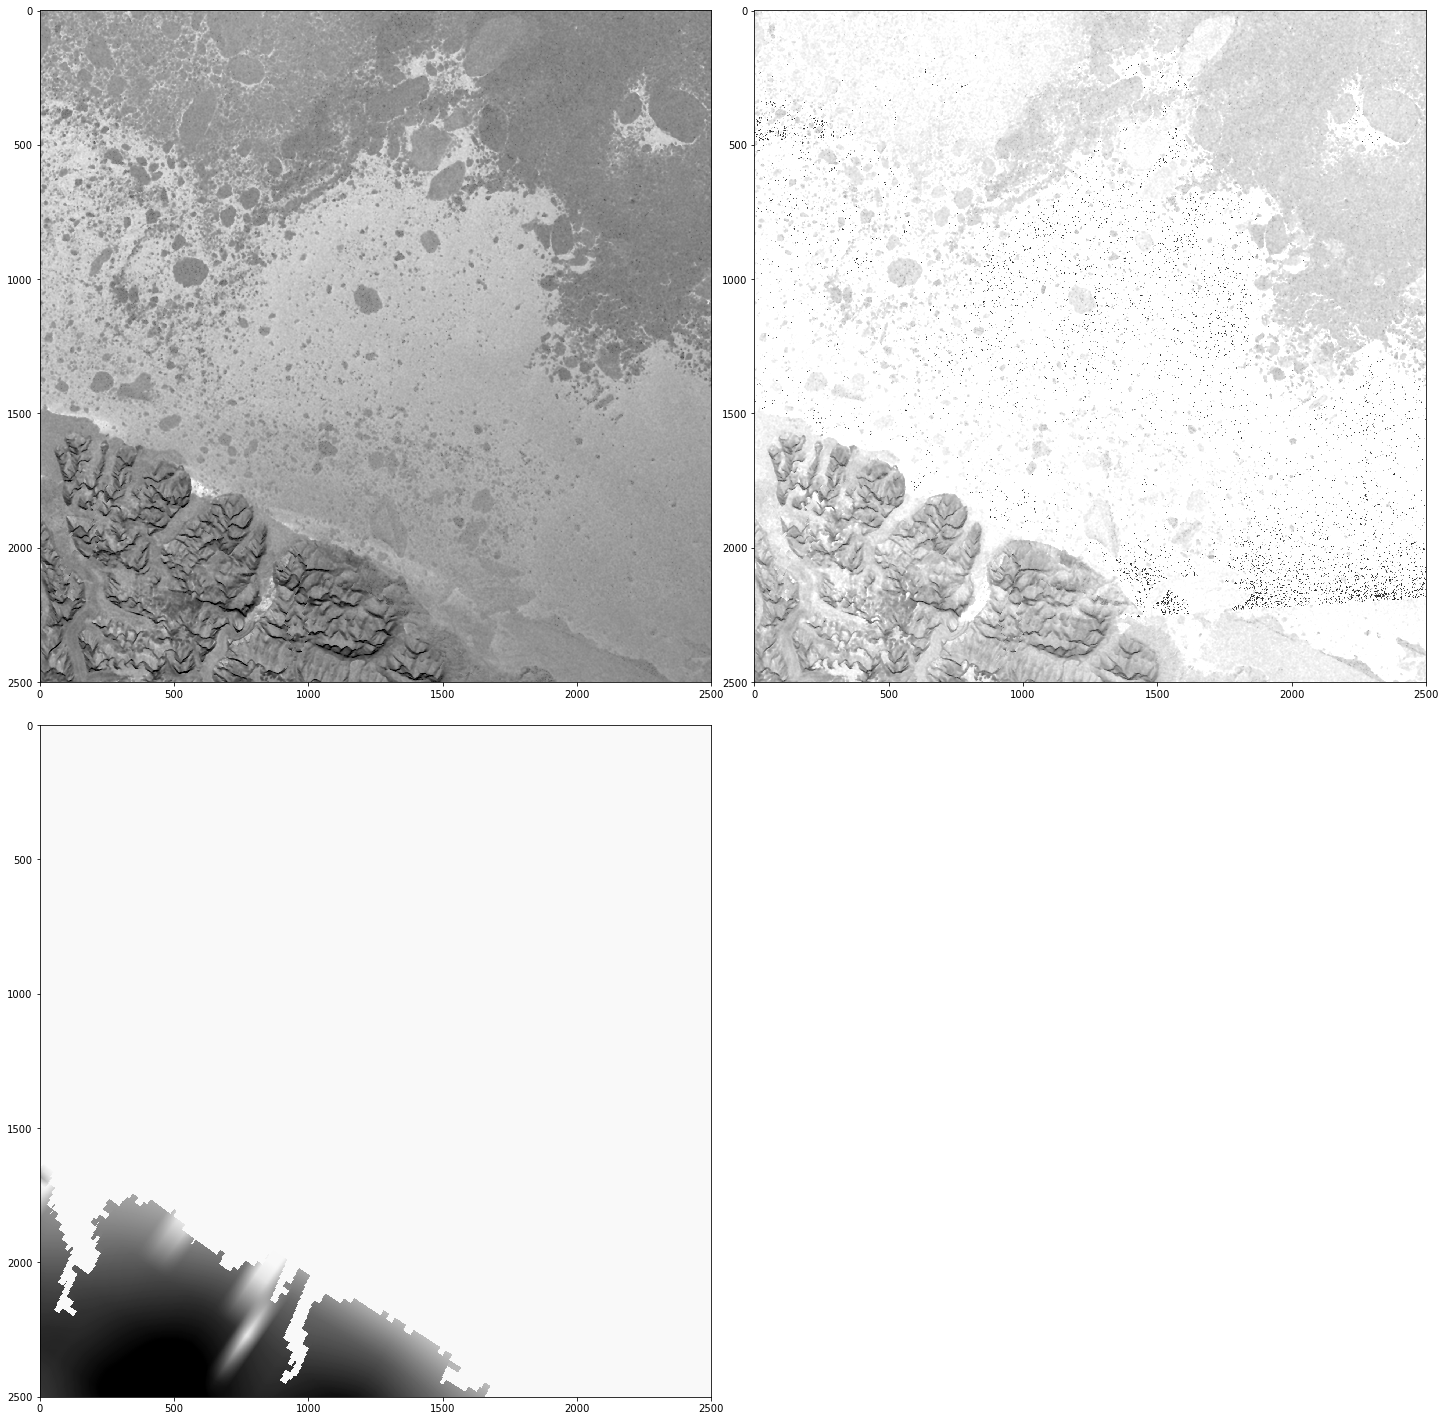

In [52]:
%matplotlib inline
import matplotlib.pyplot as plt
import gdal
import numpy as np

fig = plt.figure(figsize=(20,20))

ds = gdal.Open('sigma0.tif')

for i in range(ds.RasterCount):
    i += 1

    band = ds.GetRasterBand(i)

    a=fig.add_subplot(2, 2, 0+i)
    
    if i == 3:
        imgplot = plt.imshow(band.ReadAsArray().astype(np.float),
                         cmap=plt.cm.binary, 
                         vmin=0, 
                         vmax=1000)
    else:
        imgplot = plt.imshow(band.ReadAsArray().astype(np.float),
                         cmap=plt.cm.binary, 
                         vmin=-26, 
                         vmax=6)
    
    #a.set_title(input_identifier)

    
plt.tight_layout()
fig = plt.gcf()
plt.show()

fig.clf()
plt.close()

